In [22]:
#Importing Important Libraries
%matplotlib inline
import torch
import torch.nn as nn
from torchvision import datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split

In [23]:
# Load MNIST from file
DATA_DIR = "."
download_dataset = False

train_mnist = datasets.MNIST(DATA_DIR, train=True, download=download_dataset)
test_mnist = datasets.MNIST(DATA_DIR, train=False, download=download_dataset)

In [24]:
print(train_mnist)
print(test_mnist)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test


In [25]:
len(train_mnist)

60000

In [26]:
len(test_mnist)

10000

In [27]:
# Create variables for MNIST data
X_train = train_mnist.data.float()
y_train = train_mnist.targets
X_test = test_mnist.data.float()
y_test = test_mnist.targets

Displaying train and test samples and Images

In [28]:
print(len(X_train))
print(len(y_train))

60000
60000


In [29]:
print(X_train[0].shape)
print(y_train[0].shape)

torch.Size([28, 28])
torch.Size([])


In [30]:
print(len(X_test))
print(len(y_test))

10000
10000


In [31]:
print(X_test[0].shape)
print(y_test[0].shape)

torch.Size([28, 28])
torch.Size([])


In [33]:
X_train[0]

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,

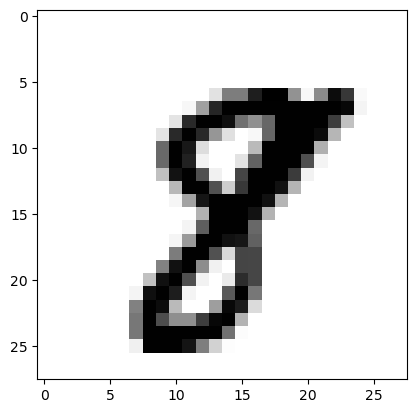

In [34]:
plt.imshow(X_train[55],cmap='binary')

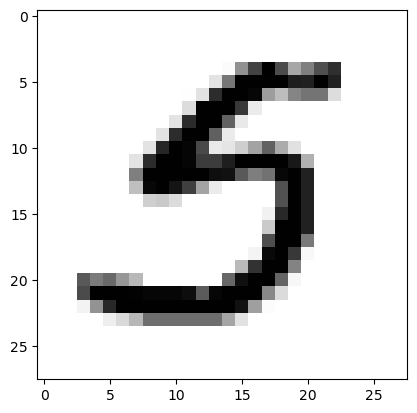

In [35]:
plt.imshow(X_train[699],cmap='binary')

Preparing Data for Model

In [38]:
X_train.shape

torch.Size([60000, 28, 28])

In [39]:
X_test.shape

torch.Size([10000, 28, 28])

In [44]:
# Re-loading MNIST from file
DATA_DIR = "."
download_dataset = False

m_train_mnist = datasets.MNIST(DATA_DIR, train=True, download=download_dataset,transform=ToTensor())
m_test_mnist = datasets.MNIST(DATA_DIR, train=False, download=download_dataset,transform=ToTensor())

len(m_train_mnist), len(m_test_mnist)

(60000, 10000)

In [45]:
# SPLITTING THE DATASET INTO TRAINING AND VALIDATION

train_ds, val_ds = random_split(m_train_mnist, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [46]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(m_test_mnist, batch_size*2)

In [47]:
len(train_loader)

391

In [48]:
len(val_loader)

40

In [49]:
len(test_loader)

40

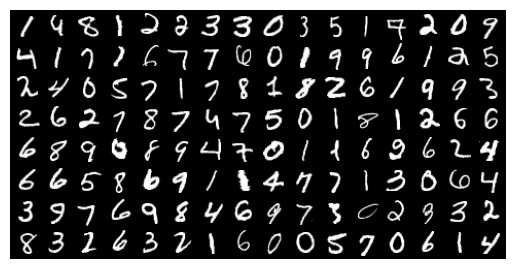

In [50]:
# VISUALIZING A BATCH OF IMAGES

for images, _ in train_loader:
  grid = make_grid(images, nrow=16).permute((1, 2, 0))
  plt.imshow(grid)
  plt.axis('off')
  break

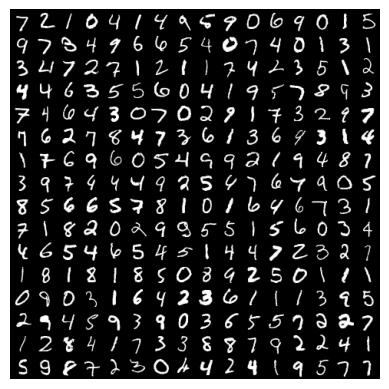

In [51]:
# VISUALIZING A BATCH OF IMAGES

for images, _ in test_loader:
  grid = make_grid(images, nrow=16).permute((1, 2, 0))
  plt.imshow(grid)
  plt.axis('off')
  break

BUILDING THE ANN NUERAL NETWORK CLASSIFICATION MODEL

In [61]:
class AnnModel(nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 64)
    self.linear2 = nn.Linear(64, 32)
    self.linear3 = nn.Linear(32, 16)
    self.linear4 = nn.Linear(16, output_size)
  
  def forward(self, x_batch):
    outputs = x_batch.reshape(-1, 784)
    outputs = self.linear4(F.relu(self.linear3(F.relu(self.linear2(F.relu(self.linear1(outputs)))))))
    return outputs

BUILDING ACCURACY AND LOSS FUNCTIONS FOR THE MODEL

In [62]:
# DEFINING ACCURACY FUNCTION
  
def accuracy_score(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  correct_preds = torch.sum(preds==labels).item()
  total_preds = len(preds)
  accuracy = torch.tensor(correct_preds/total_preds)
  return accuracy

DEFINING VALIDATION FUNCTIONS

In [63]:
# DEFINING VALIDATION FUNCTIONS

def validation_step(model, batch):
  images, labels = batch
  loss = F.cross_entropy(model.forward(images), labels)
  acc = accuracy_score(model.forward(images), labels)
  return {'val_loss':loss, 'val_acc':acc}

def validation_epoch_end(outputs):  
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

def evaluate(model, val_loader):
  metrics = [validation_step(model, batch) for batch in val_loader]
  metrics = validation_epoch_end(metrics)
  return metrics

In [66]:
# DEFINING THE FIT FUNCTION

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):

    for batch in train_loader:
      images, labels = batch
      loss = F.cross_entropy(model.forward(images), labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    metrics = evaluate(model, val_loader)
    print('Epoch #', epoch+1, '|', 'Validation loss:', round(metrics['val_loss'], 3), '|', 'Validation accuracy:', round(metrics['val_acc']*100, 3), '%')
    
    history.append(metrics)
  
  return history

In [67]:
# TRAINING THE MODEL

model = AnnModel(784, 10)

history = [evaluate(model, val_loader)]
print('Metrics before training:')
print(history)
print()
print('Metrics after training for x number of epochs:')
history += fit(10, 0.4, model, train_loader, val_loader)

Metrics before training:
[{'val_loss': 2.3126649856567383, 'val_acc': 0.10498046875}]

Metrics after training for x number of epochs:
Epoch # 1 | Validation loss: 0.404 | Validation accuracy: 87.871 %
Epoch # 2 | Validation loss: 0.178 | Validation accuracy: 94.746 %
Epoch # 3 | Validation loss: 0.15 | Validation accuracy: 95.625 %
Epoch # 4 | Validation loss: 0.142 | Validation accuracy: 96.113 %
Epoch # 5 | Validation loss: 0.13 | Validation accuracy: 96.064 %
Epoch # 6 | Validation loss: 0.117 | Validation accuracy: 96.895 %
Epoch # 7 | Validation loss: 0.134 | Validation accuracy: 96.436 %
Epoch # 8 | Validation loss: 0.118 | Validation accuracy: 96.66 %
Epoch # 9 | Validation loss: 0.132 | Validation accuracy: 96.689 %
Epoch # 10 | Validation loss: 0.123 | Validation accuracy: 96.787 %


Text(0.5, 1.0, 'loss vs no of epochs')

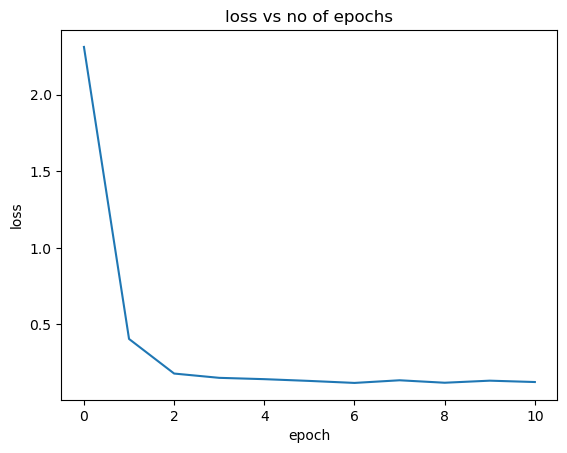

In [68]:
# PLOTTING LOSS DATA ON GRAPH

losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs no of epochs')

Text(0.5, 1.0, 'accuracy vs no of epochs')

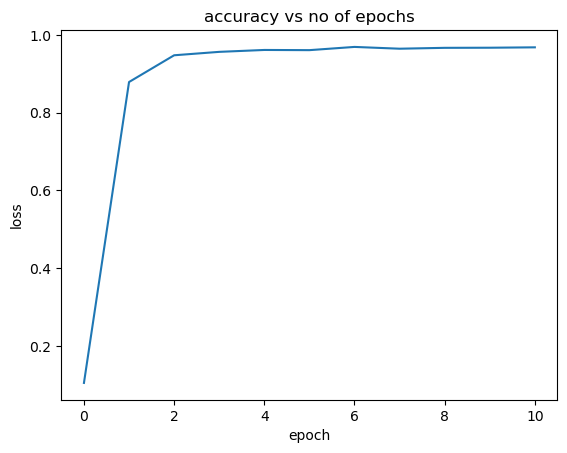

In [69]:
# PLOTTING ACCURACY DATA ON GRAPH

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('accuracy vs no of epochs')

TESTING MODEL PERFORMANCE

Label: 3
Predicted: tensor([3])


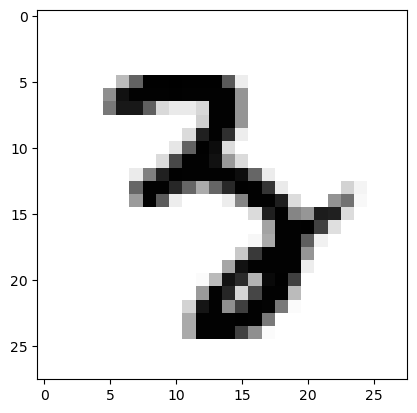

In [75]:
def predict_image(image):
  image = image.reshape(-1, 784) 
  outputs = model.forward(image)
  _, prediction = torch.max(outputs, dim=1)
  return prediction

image, label = m_test_mnist[87]
plt.imshow(image[0], cmap='binary')
print('Label:', label)
print('Predicted:', predict_image(image))

SAVING MODEL

In [76]:
neural_classify_model = model
torch.save(model.state_dict(), 'neural_classify_model.pth')